# Binary classification in Python

## Case: Retention Modeling at Scholastic Travel Company (А)

This notebooks builds on the notebook with the linear regression analyses for the "Sarah Gets a Diamond" case from Day 1, and modifies it for the new case. The main steps are the following:


1.   Make sure that the required packages and libraries are install (and install if they are not)
2.   Load the required packages and libraries
3.   Load the data
4.   "Clean" the data: in this case the data are much "dirtier" than in the Sarah case, and we will need to (4.1) convert some features into correct types, (4.2) combine rate categories, (4.3) fix the missing values, and (4.4) create dummies (one-hot-encoding) for the non-numerical features
5.   Define the taret vector (the variable we are trying to predict) and the matrix of features (all others, except ID)
6.   Split the data into training and testing; this time we will do so randomly and with stratification
7.   Train (fit) the model on the training data 
8.   Apply it to the testing data 
9.   Calculate model metrics and tune hyper-parameters to improve those metrics
10.  Export the predictions for decisoin making [the case does not have an explicit prediction data, so we will export the testing set predictions instead] 

ML method: Support Vector Machines -- a method somewhat inbetween regressions and trees that fits lower-dimentional planes to separate the data into classes with maximal margin between them

### Step 0: To start ... 

In [1]:
# Turn on multi-threading on your computer for faster calculation 
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


# Steps 1 and 2: Install and load the necessary packages and libraries

In [2]:
# Step 1: Check conda environment and installed packages and libaries
# import sys
# !conda env list
# !conda list
# !conda update --all

# Download and install pandas, numpy, scikit-learn. Note, this might need to be done in Anaconda prompt
# !conda install pandas # pandas includes numpy 
# !conda install scikit-learn

# Step 2: Load the necessary packages and libaries 

import numpy as np # recall that "np" etc. -- are abbreviated names we gave to these packages for notational convenience
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

# Step 3: Load the data

In [3]:
# Step 3: Load the data from the CSV file into the dataframe that we called df.
path = "03 CSV data -- STC(A)_numerical dates.csv"
df = pd.read_csv(path, header = 0) #, encoding = "ISO-8859-1")
df.head() # show the "head" -- first 5 rows of the data; note, these are rows 0...4

,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,...,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.
0,1,HS,4.0,4.0,CA,0,1,A,40557,40557,...,K,Elementary,K->Elementary,H,1,0.063646,0.936508,4,L,1
1,2,HC,8.0,8.0,AZ,0,7,A,40557,40564,...,Middle,Middle,Middle->Middle,H,1,0.025882,0.880000,3,L,1
2,3,HD,8.0,8.0,FL,0,3,A,40558,40560,...,Middle,Middle,Middle->Middle,H,1,0.025131,0.888889,3,L,1
3,4,HN,9.0,12.0,VA,1,3,B,40558,40560,...,Undefined,Undefined,Undefined->Undefined,H,0,NaN,1.000000,0,NaN,0
4,5,HD,6.0,8.0,FL,0,6,T,40559,40564,...,Middle,Middle,Middle->Middle,H,0,0.112500,0.910112,8,M-L,0


# Step 4: "Cleaning" the data

In this case the data are purposefully left slightly "dirty", that is, they are pre-cleaned somewhat, but for learning purposes some elements of dirty data still remain: 

1. Some datafields (variables, features, columns) have incorect types -- they should be converted, for instance, from numbers to categoricals 
    
2. Some categorical variables have too many categories (levels), and some of the levels are too rare: for instance, there is only one group from Bahamas (why is this a problem?) -- such data should be merged into more populous category
    
3. Some data are missing and we need to replace or impute them 

To conclude data cleaning we will, of course, have to create dummy variables ("one hot encoding") for the categorical variables
 

In [4]:
# "Cleaning" the data -- part 1: converting incorrect data types

# Some of python data types:
# int -- integer number (e.g., 5)
# float -- fractional number (e.g., 5.25)
# object, str -- text (string). A text that contains several unordered values (e.g., M/F) is called "categogy"

df.info() # Checking what kinds of data we have 

# Other data types in the pandas package:
# category -- categorical, same as "factor" in R (e.g., red/green/blue, or M/F: a list with several unordered values)
# datetime -- date and time (e.g., 01.01.2020)
# bool -- binary (e.g.? yes/no, 1/0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389 entries, 0 to 2388
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              2389 non-null   int64  
 1   Program.Code                    2389 non-null   object 
 2   From.Grade                      2262 non-null   float64
 3   To.Grade                        2239 non-null   float64
 4   Group.State                     2389 non-null   object 
 5   Is.Non.Annual.                  2389 non-null   int64  
 6   Days                            2389 non-null   int64  
 7   Travel.Type                     2389 non-null   object 
 8   Departure.Date                  2389 non-null   int64  
 9   Return.Date                     2389 non-null   int64  
 10  Deposit.Date                    2389 non-null   int64  
 11  Special.Pay                     470 non-null    object 
 12  Tuition                         23

In [5]:
# "Cleaning" the data -- part 1: converting data types that should be categorican into "category"

df['From.Grade'] = df['From.Grade'].astype('category')
df['To.Grade'] = df['To.Grade'].astype('category')
df['Is.Non.Annual.'] = df['Is.Non.Annual.'].astype('category')
df['Parent.Meeting.Flag'] = df['Parent.Meeting.Flag'].astype('category')
df['Days'] = df['Days'].astype('category')
df['CRM.Segment'] = df['CRM.Segment'].astype('category')
df['MDR.High.Grade'] = df['MDR.High.Grade'].astype('category')
df['School.Sponsor'] = df['School.Sponsor'].astype('category')
df['NumberOfMeetingswithParents'] = df['CRM.Segment'].astype('category')
df['SingleGradeTripFlag'] = df['SingleGradeTripFlag'].astype('category')

df.info() # let check the result

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389 entries, 0 to 2388
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              2389 non-null   int64   
 1   Program.Code                    2389 non-null   object  
 2   From.Grade                      2262 non-null   category
 3   To.Grade                        2239 non-null   category
 4   Group.State                     2389 non-null   object  
 5   Is.Non.Annual.                  2389 non-null   category
 6   Days                            2389 non-null   category
 7   Travel.Type                     2389 non-null   object  
 8   Departure.Date                  2389 non-null   int64   
 9   Return.Date                     2389 non-null   int64   
 10  Deposit.Date                    2389 non-null   int64   
 11  Special.Pay                     470 non-null    object  
 12  Tuition             

In [6]:
# "Cleaning" the data -- part 2: combining rate categories ("levels")

df['Group.State'].value_counts() # To get the intuition lets examine the column Group.State

# Here is the code to check all columns, in case you're interested
# for col in df.select_dtypes(include=['category','object','bool']).columns:
#    print(col)
#    print(df[col].value_counts())
#    print('\n') 


CA                718
TX                308
WA                147
IL                104
CO                 89
MI                 71
FL                 62
AZ                 53
OH                 53
MN                 51
OR                 51
WI                 46
IN                 43
MO                 43
NE                 42
TN                 38
MA                 36
IA                 35
OK                 33
LA                 31
KS                 26
GA                 22
AL                 21
NV                 20
NM                 20
NY                 19
VA                 18
KY                 16
NC                 16
MD                 15
CT                 15
ID                 14
SD                 11
AR                 10
SC                 10
HI                  9
MS                  9
UT                  9
ME                  7
NH                  7
MT                  6
NJ                  6
AK                  5
PA                  5
ND                  5
RI        

In [7]:
# "Cleaning" the data -- part 2: combining rate categories ("levels")

# Here is a custom function that we called CombineRareCategories
# this function has two arguments: the name of the dataframe (data) and the minimal number of datapoints to remain a separate category (mincount)
# this function will loop through all the columns in the dataframe, and will combine all categories that appear in the data les than mincount number of times into (Other)

def CombineRareCategories(data, mincount):
    for col in data.columns:
        if (type(data[col][0]) == str):
            for index, row in pd.DataFrame(data[col].value_counts()).iterrows():
                if ( row[0] < mincount):
                    df[col].replace(index, 'Other_' + col, inplace = True)
                else:
                    None

# lets apply this functino to our data with mincount=10                    
CombineRareCategories(df, 10)        

df[0:10] #lets check the result

,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,...,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.
0,1,HS,4.0,4.0,CA,0,1,A,40557,40557,...,K,Elementary,K->Elementary,H,1,0.063646,0.936508,4,L,1
1,2,HC,8.0,8.0,AZ,0,7,A,40557,40564,...,Middle,Middle,Middle->Middle,H,1,0.025882,0.880000,3,L,1
2,3,HD,8.0,8.0,FL,0,3,A,40558,40560,...,Middle,Middle,Middle->Middle,H,1,0.025131,0.888889,3,L,1
3,4,HN,9.0,12.0,VA,1,3,B,40558,40560,...,Undefined,Undefined,Undefined->Undefined,H,0,NaN,1.000000,0,NaN,0
4,5,HD,6.0,8.0,FL,0,6,Other_Travel.Type,40559,40564,...,Middle,Middle,Middle->Middle,H,0,0.112500,0.910112,8,M-L,0
5,6,HC,10.0,12.0,LA,0,4,A,40560,40563,...,High,High,High->High,H,0,0.010650,0.909091,1,L,1
6,7,SG,11.0,12.0,MA,1,6,A,40561,40566,...,High,High,High->High,S,0,0.111111,0.925926,2,S,0
7,8,Other_Program.Code,9.0,9.0,Other_Group.State,0,8,A,40567,40574,...,Undefined,Undefined,Undefined->Undefined,I,1,NaN,0.928571,1,NaN,0
8,9,CC,8.0,8.0,AZ,0,8,A,40572,40579,...,Middle,High,Middle->High,C,1,0.104000,0.928571,4,S-M,1
9,10,HD,8.0,8.0,TX,0,4,A,40581,40584,...,PK,Middle,PK->Middle,H,1,0.103937,0.916667,6,M-L,1


In [8]:
pd.DataFrame(df['Program.Code'].value_counts()).iterrows()

<generator object DataFrame.iterrows at 0x7fa1032580b0>

In [9]:
# "Cleaning" the data -- part 3: replacing/imputing missing data

pd.DataFrame(df).isna().sum() # Lets check if we have any missing data -- the result shows that yes, and a lot

ID                                   0
Program.Code                         0
From.Grade                         127
To.Grade                           150
Group.State                          0
Is.Non.Annual.                       0
Days                                 0
Travel.Type                          0
Departure.Date                       0
Return.Date                          0
Deposit.Date                         0
Special.Pay                       1919
Tuition                              0
FRP.Active                           0
FRP.Cancelled                        0
FRP.Take.up.percent.                 0
Early.RPL                          673
Latest.RPL                          19
Cancelled.Pax                        0
Total.Discount.Pax                   0
Initial.System.Date                  8
Poverty.Code                       599
Region                               0
CRM.Segment                          4
School.Type                          0
Parent.Meeting.Flag      

In [10]:
# "Cleaning" the data -- part 3: replacing/imputing missing data

# Approach:
# Categorical features: adding new category 'missing_value' (as if this is a new color, or gender)
# Numerical features: replacing with a median (or mean, or most frequent value, etc.) An alternative approach is to imputate, see here: https://scikit-learn.org/stable/modules/impute.html 
# + we add surrogate columns indicating that the value is imputed

# creating surrogates
for col in df:
    if df[col].isna().sum() != 0: 
        df[col + '_surrogate'] = df[col].isna().astype(int)

# fixing categoricals
imputer = SimpleImputer(missing_values = np.nan, strategy='constant')
imputer.fit(df.select_dtypes(exclude=['int64','float64']))
df[df.select_dtypes(exclude=['int64','float64']).columns] = imputer.transform(df.select_dtypes(exclude=['int64','float64']))
           
# fixing numericals 
imputer = SimpleImputer(missing_values = np.nan, strategy='median')
imputer.fit(df.select_dtypes(include=['int64','float64']))
df[df.select_dtypes(include=['int64','float64']).columns] = imputer.transform(df.select_dtypes(include=['int64','float64']))

# Lets examine the result, e.g., datafield "Poverty.Code"
df[['Poverty.Code','Poverty.Code_surrogate']]


,Poverty.Code,Poverty.Code_surrogate
0,B,0.0
1,C,0.0
2,C,0.0
3,missing_value,1.0
4,D,0.0
...,...,...
2384,C,0.0
2385,C,0.0
2386,missing_value,1.0
2387,missing_value,1.0


In [11]:
# "Cleaning" the data -- wrapping up: creating dummy variables for non-numbers ("one hot encoding")
df = pd.get_dummies(df, columns = df.select_dtypes(exclude=['int64','float64']).columns, drop_first = True)

pd.options.display.max_columns = None # remove the limit on the number of columns by default only 20 are shows

df.head()  # our dataset now has 252 columns(!)

,ID,Departure.Date,Return.Date,Deposit.Date,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Early.RPL,Latest.RPL,Cancelled.Pax,Total.Discount.Pax,Initial.System.Date,Total.School.Enrollment,EZ.Pay.Take.Up.Rate,FPP,Total.Pax,SPR.Group.Revenue,FirstMeeting,LastMeeting,DifferenceTraveltoFirstMeeting,DifferenceTraveltoLastMeeting,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,Retained.in.2012.,From.Grade_surrogate,To.Grade_surrogate,Special.Pay_surrogate,Early.RPL_surrogate,Latest.RPL_surrogate,Initial.System.Date_surrogate,Poverty.Code_surrogate,CRM.Segment_surrogate,MDR.Low.Grade_surrogate,MDR.High.Grade_surrogate,Total.School.Enrollment_surrogate,Income.Level_surrogate,NumberOfMeetingswithParents_surrogate,FirstMeeting_surrogate,LastMeeting_surrogate,DifferenceTraveltoFirstMeeting_surrogate,DifferenceTraveltoLastMeeting_surrogate,FPP.to.School.enrollment_surrogate,SchoolSizeIndicator_surrogate,Program.Code_CD,Program.Code_HC,Program.Code_HD,Program.Code_HG,Program.Code_HN,Program.Code_HO,Program.Code_HS,Program.Code_HVP,Program.Code_IC,Program.Code_Other_Program.Code,Program.Code_SC,Program.Code_SG,Program.Code_SK,Program.Code_SM,Program.Code_ST,From.Grade_4.0,From.Grade_5.0,From.Grade_6.0,From.Grade_7.0,From.Grade_8.0,From.Grade_9.0,From.Grade_10.0,From.Grade_11.0,From.Grade_12.0,From.Grade_missing_value,To.Grade_4.0,To.Grade_5.0,To.Grade_6.0,To.Grade_7.0,To.Grade_8.0,To.Grade_9.0,To.Grade_10.0,To.Grade_11.0,To.Grade_12.0,To.Grade_missing_value,Group.State_AR,Group.State_AZ,Group.State_CA,Group.State_CO,Group.State_CT,Group.State_FL,Group.State_GA,Group.State_IA,Group.State_ID,Group.State_IL,Group.State_IN,Group.State_KS,Group.State_KY,Group.State_LA,Group.State_MA,Group.State_MD,Group.State_MI,Group.State_MN,Group.State_MO,Group.State_NC,Group.State_NE,Group.State_NM,Group.State_NV,Group.State_NY,Group.State_OH,Group.State_OK,Group.State_OR,Group.State_Other_Group.State,Group.State_SC,Group.State_SD,Group.State_TN,Group.State_TX,Group.State_VA,Group.State_WA,Group.State_WI,Is.Non.Annual._1,Days_2,Days_3,Days_4,Days_5,Days_6,Days_7,Days_8,Days_9,Days_10,Days_11,Days_12,Travel.Type_B,Travel.Type_Other_Travel.Type,Special.Pay_FR,Special.Pay_SA,Special.Pay_missing_value,Poverty.Code_B,Poverty.Code_C,Poverty.Code_D,Poverty.Code_E,Poverty.Code_Other_Poverty.Code,Poverty.Code_missing_value,Region_Houston,Region_Northern California,Region_Other,Region_Pacific Northwest,Region_Southern California,CRM.Segment_2.0,CRM.Segment_3.0,CRM.Segment_4.0,CRM.Segment_5.0,CRM.Segment_6.0,CRM.Segment_7.0,CRM.Segment_8.0,CRM.Segment_9.0,CRM.Segment_10.0,CRM.Segment_11.0,CRM.Segment_missing_value,School.Type_Catholic,School.Type_PUBLIC,School.Type_Private non-Christian,Parent.Meeting.Flag_1,MDR.Low.Grade_4,MDR.Low.Grade_5,MDR.Low.Grade_6,MDR.Low.Grade_7,MDR.Low.Grade_8,MDR.Low.Grade_9,MDR.Low.Grade_K,MDR.Low.Grade_Other_MDR.Low.Grade,MDR.Low.Grade_PK,MDR.Low.Grade_missing_value,MDR.High.Grade_2.0,MDR.High.Grade_3.0,MDR.High.Grade_4.0,MDR.High.Grade_5.0,MDR.High.Grade_6.0,MDR.High.Grade_7.0,MDR.High.Grade_8.0,MDR.High.Grade_9.0,MDR.High.Grade_10.0,MDR.High.Grade_11.0,MDR.High.Grade_12.0,MDR.High.Grade_missing_value,Income.Level_B,Income.Level_C,Income.Level_D,Income.Level_E,Income.Level_F,Income.Level_G,Income.Level_H,Income.Level_I,Income.Level_J,Income.Level_K,Income.Level_L,Income.Level_M,Income.Level_N,Income.Level_O,Income.Level_Other_Income.Level,Income.Level_P,Income.Level_Q,Income.Level_Z,Income.Level_missing_value,School.Sponsor_1,SPR.Product.Type_Costa Rica,SPR.Product.Type_East Coast,SPR.Product.Type_International,SPR.Product.Type_Other_SPR.Product.Type,SPR.Product.Type_Science,SPR.New.Existing_NEW,NumberOfMeetingswithParents_2.0,NumberOfMeetingswithParents_3.0,NumberOfMeetingswithParents_4.0,NumberOfMeetingswithParents_5.0,NumberOfMeetingswithParents_6.0,NumberOfMeetingswithParents_7.0,NumberOfMeetingswithParents_8.0,NumberOfMeetingswithParents_9.0,NumberOfMeetingswithParents_10.0,NumberOfMeetingswithParents_11.0,NumberOfMeet

# Step 5:  Defining the vector of target (y) and matrix of features (X)

In [12]:
y = df['Retained.in.2012.']
X = df.drop(columns = 'Retained.in.2012.')

In [13]:
y.describe()

count    2389.000000
mean        0.607367
std         0.488439
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Retained.in.2012., dtype: float64

# Step 6:  Splitting X and y into training and testing

In [14]:
# For "apples-to-apples" comparisons, set a starting value ("seed") for the random number generator
np.random.seed(77300)

# split the data randomly into 80% train and 20% test samples 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, stratify=y)
# IMPORTANT: these samples are stratified, i.e., the proportion of retained and not-retained customers is the same in both

# Lets check the results
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1911, 261)
(478, 261)
(1911,)
(478,)


# Steps 7, 8, 9: Train a model on the training data, Use it to predict the values in the testing data, Compute the metrics of the model and compare models

In [15]:
# First we define a set of functions to compute the metrics of the model

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

# Method: Support Vector Machines

In [16]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_estimators = []
svm_estimators.append(('standardize', StandardScaler())) # scale the data
svm_estimators.append(('SVM', svm.SVC(probability=True))) # define SVM with probabilities (recall, SVM be default does not predict probabilities)
     
# Define the support vectors machine model and call it classifier_SVM
Classifier_SVM = Pipeline(svm_estimators, verbose=False)

# Train the model classifier_SVM on the training data
Classifier_SVM.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('svm', SVC(probability=True))])

Metrics of the Support Vector Machines model: 

Confusion matrix: 
[[147  62]
 [ 41 228]]
                                   Accuracy: 0.7845188284518828
                   SENSITIVITY (aka RECALL): 0.7862068965517242
                 SPECIFICITY (aka FALL-OUT): 0.7819148936170213
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8475836431226765
                 NEGATIVE PREDICTIVE VALUE): 0.7033492822966507


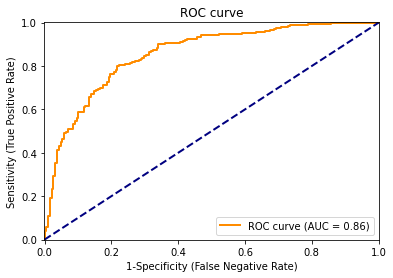

 AUC: 0.8555392516507704


In [17]:
# Select the threshold value -- we will use Т=0.6073. Why? Why not 50%? Because 60.73% -- is the average probability of retention in our data (1451 "1"s out of 2389 datapoints) 
class_threshold = 0.6073

# use the fitted model to predict the testing data 
y_pred_prob = Classifier_SVM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Support Vector Machines model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

## Summary for SVM: 

- we trained the model with default hyper-parameters
- applying it to testing set we got AUC=85.7%
- SVM also has multiple hyper-parameters, but I hope you know how to find them, and tune them -- good luck!

# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [19]:
steps = [("scaler", StandardScaler()), ('SVM', svm.SVC(probability = True))]
pipeline = Pipeline(steps)

In [20]:
# Selección de la métrica que queremos mejorar
score_func = make_scorer(roc_auc_score, greater_is_better = True)

In [21]:
# Definir la variación de los hiperparametros
param_grid = {'SVM__C': [0.1, 1, 10],
              'SVM__kernel': ['rbf' , 'lineal', 'poly']
            }

In [22]:
# Grid search
grid = GridSearchCV(pipeline, param_grid = param_grid, cv = 5, scoring = score_func, refit = True, verbose = 3, return_train_score = True)

In [23]:
grid_search = grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END SVM__C=0.1, SVM__kernel=rbf;, score=(train=0.553, test=0.528) total time=   1.2s
[CV 2/5] END SVM__C=0.1, SVM__kernel=rbf;, score=(train=0.549, test=0.514) total time=   1.2s
[CV 3/5] END SVM__C=0.1, SVM__kernel=rbf;, score=(train=0.541, test=0.527) total time=   1.2s
[CV 4/5] END SVM__C=0.1, SVM__kernel=rbf;, score=(train=0.561, test=0.536) total time=   1.2s
[CV 5/5] END SVM__C=0.1, SVM__kernel=rbf;, score=(train=0.533, test=0.537) total time=   1.2s
[CV 1/5] END SVM__C=1, SVM__kernel=rbf;, score=(train=0.899, test=0.753) total time=   1.2s
[CV 2/5] END SVM__C=1, SVM__kernel=rbf;, score=(train=0.891, test=0.743) total time=   1.1s
[CV 3/5] END SVM__C=1, SVM__kernel=rbf;, score=(train=0.884, test=0.768) total time=   1.1s
[CV 4/5] END SVM__C=1, SVM__kernel=rbf;, score=(train=0.896, test=0.754) total time=   1.1s
[CV 5/5] END SVM__C=1, SVM__kernel=rbf;, score=(train=0.890, test=0.769) total time=   1.2s
[CV 1/5] E

In [24]:
print(grid.best_params_)
print(grid.best_estimator_)

{'SVM__C': 1, 'SVM__kernel': 'rbf'}
Pipeline(steps=[('scaler', StandardScaler()),
                ('SVM', SVC(C=1, probability=True))])


In [25]:
grid_predictions = grid.predict(X_test)

In [26]:
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72       188
         1.0       0.81      0.84      0.83       290

    accuracy                           0.78       478
   macro avg       0.78      0.77      0.77       478
weighted avg       0.78      0.78      0.78       478



# Step 10: Finishing the anlayses -- export the model predictions for subsequent use

In [27]:
# If we have the prediction data (e.g., about the new clients) the load and clean them first to obtain the X_pred matrix of exactly the same structure as X_train 
# in our case there is no such data, so we will predict the testign data and export the resultant predictions
X_pred = X_test

# Which model should we take? 

# Since the random forest model with optimized hyper-parameters obtained the higest AUC, lets take that; recall it is called grid_search_RF
y_pred_prob = grid.predict_proba(X_pred)[:,1]   

# Lets add the ID column to know "who is who"
Prediction = pd.DataFrame(data={"ID":X_pred["ID"],"Predicted Probability":y_pred_prob}) 

# Export the predictions into a CSV file
Prediction.to_csv("Predicted Retention Probability_testing.csv",sep = ',')